## Klasifikasi Wilayah

### 1. Import Library

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

### 2. Dataset Understanding

In [22]:
df = pd.read_csv("../data/segmentasi_labelled_dataset.csv")
df.head()

,province,cities_reg,poorpeople_percentage,reg_gdp,life_exp,avg_schooltime,exp_percap,Cluster
0,Aceh,Simeulue,18.98,2.275,65.240,9.48,7148.0,0
1,Aceh,Aceh Singkil,20.36,2.425,67.355,8.68,8776.0,0
2,Aceh,Aceh Selatan,13.18,5.531,64.360,8.88,8180.0,0
3,Aceh,Aceh Tenggara,13.41,5.063,68.155,9.67,8030.0,0
4,Aceh,Aceh Timur,14.45,10.616,68.705,8.21,8577.0,0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   province               514 non-null    object 
 1   cities_reg             514 non-null    object 
 2   poorpeople_percentage  514 non-null    float64
 3   reg_gdp                514 non-null    float64
 4   life_exp               514 non-null    float64
 5   avg_schooltime         514 non-null    float64
 6   exp_percap             514 non-null    float64
 7   Cluster                514 non-null    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 32.2+ KB


### 3. Preprocessing

In [24]:
# Dataset yg digunakan adalah numerik
numeric_column = df.select_dtypes(include=['float64']).columns
numeric_fetures = df[numeric_column]

# Standardisasi
scaler = StandardScaler()
numeric_fetures = scaler.fit_transform(numeric_fetures)

In [25]:
# Data Splitting
X = numeric_fetures
y = df['Cluster']

# Split data ke train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Oversampling dengan SMOTE
smote = SMOTE(sampling_strategy=0.8, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### 4. Modelling

In [27]:
# Inisialisasi Algoritma Klasifikasi
knn = KNeighborsClassifier().fit(X_train_resampled,y_train_resampled)
rf = LogisticRegression().fit(X_train_resampled,y_train_resampled)

### 5. Evaluasi

                       Model  Accuracy  Precision  Recall  F1-Score
0  K-Nearest Neighbors (KNN)  0.990291        1.0     0.5  0.666667
1         Random Forest (RF)  0.990291        1.0     0.5  0.666667


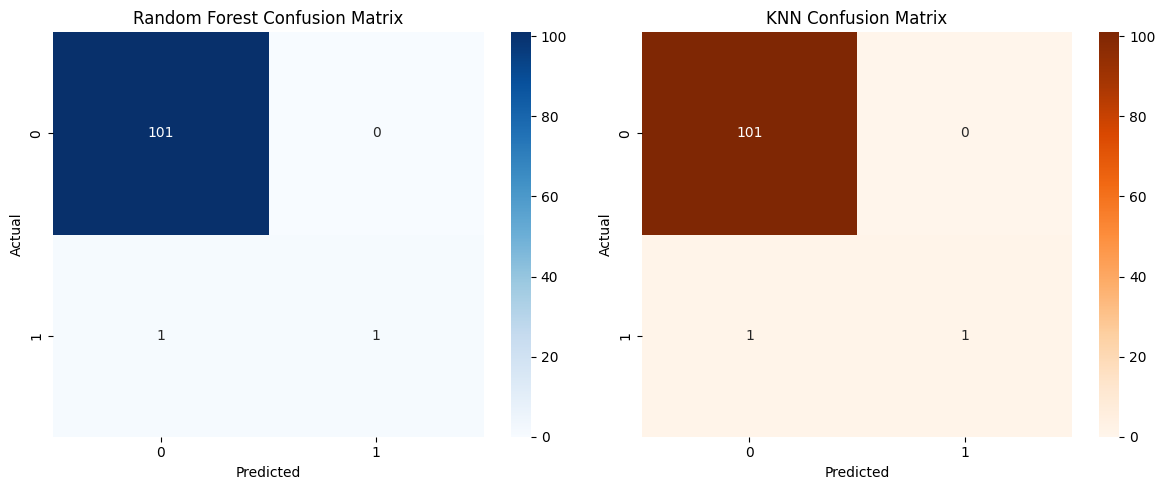

In [28]:
def evaluate_model(model, X_test, y_test, threshold=0.5):
    # y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]

    # Terapkan threshold baru
    y_pred = (y_probs >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    results = {
        'Confusion Matrix': cm,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }
    return results

threshold_value = 0.5
results = {
    'K-Nearest Neighbors (KNN)': evaluate_model(knn, X_test, y_test, threshold=threshold_value),
    'Random Forest (RF)': evaluate_model(rf, X_test, y_test, threshold=threshold_value),
}

# Buat DataFrame untuk meringkas hasil
summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Isi DataFrame dengan hasil
rows = []
for model_name, metrics in results.items():
    rows.append({
        'Model': model_name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score']
    })

# Konversi daftar kamus ke DataFrame
summary_df = pd.DataFrame(rows)

# Tampilkan DataFrame
print(summary_df)


# Generate predictions
y_pred_rf = rf.predict(X_test)
y_pred_knn = knn.predict(X_test)

# Create subplots
plt.figure(figsize=(12, 5))

# Random Forest Confusion Matrix
plt.subplot(1, 2, 1)
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# KNN Confusion Matrix
plt.subplot(1, 2, 2)
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


In [29]:
# simpan model
bundle = {
    "model": rf,
    "scaler": scaler
}


path = "../models/segmentasi_bundle.pkl"
os.makedirs(os.path.dirname(path), exist_ok=True)
joblib.dump(bundle, path)
print(f"Model dan scaler telah tersimpan di: {path}")

Model dan scaler telah tersimpan di: ../models/segmentasi_bundle.pkl
